In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from symfit import parameters, variables, sin, cos, Fit

## Loading points

In [3]:
loaded = np.load('points.npz', allow_pickle=True)

In [3]:
class SnakeFitter:
    def __init__(self, all_x, all_y, collect_x, collect_y, new_x, new_y, n=7):
        self.ax = all_x
        self.ay = all_y
        self.cx = collect_x
        self.cy = collect_y
        self.nx = new_x
        self.ny = new_y
        self.n = n
    
    def fourier_series(self, x, f):
        """
        Returns a symbolic fourier series of order `n`.

        :param n: Order of the fourier series.
        :param x: Independent variable
        :param f: Frequency of the fourier series
        """
        # Make the parameter objects for all the terms
        a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, self.n + 1)]))
        sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, self.n + 1)]))
        # Construct the series
        series = a0 + sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                         for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
        return series
    
    def fit(self, k=0):
        x, y = variables('x, y')
        self.w, = parameters('w')
        model_dict = {y: self.fourier_series(x, f=self.w)}
        print(model_dict)

        # Make step function data
        xdata = self.nx[k]
        ydata = self.ny[k]
        # Define a Fit object for this model and data
        fit = Fit(model_dict, x=xdata, y=ydata)
        self.fit_result = fit.execute()
        self.a0 = self.fit_result.params['a0']
        self.w = self.fit_result.params['w']
        self.cos_a = [self.fit_result.params['a'+str(j)] for j in range(1,self.n+1)]
        self.sin_b = [self.fit_result.params['b'+str(j)] for j in range(1,self.n+1)]
        
    def get_value(self, x):
        series = self.a0 + np.sum((ai*np.cos(i*self.w*x)+bi*np.sin(i*self.w*x) 
                               for i,(ai,bi) in enumerate(zip(self.cos_a, self.sin_b), start=1)),axis=1)
        return series
    
    def plot_graph(self, k=0):
        xd, yd, yn = self.nx[k], self.ny[k], self.get_value_with_t(self.nx[k],k)
        plt.plot(xd, yd, 'g', label='data')
        plt.plot(xd, yn, 'r.', label='fit')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()
    
    def manual_phase_calculator(self):
        for i in range(len(self.cy)):
            min_dist = 100000000000000000000
            min_ind = -1
            for j in range(i+1, len(self.cy)):
                if len(self.cy[i])==len(self.cy[j]):
                    dist = np.linalg.norm(np.array(self.cy[i])-np.array(self.cy[j]))
                else:
                    common_length = min(len(self.cy[i]),len(self.cy[j]))
                    dist = np.linalg.norm(np.array(self.cy[i][:common_length])-np.array(self.cy[j][:common_length]))
                if dist < min_dist:
                    min_dist = dist
                    min_ind = j
            break
        print(min_ind)
        self.manual_time_period = min_ind
        
    def automatic_phase_shift(self):
        dy_dt, d2y_dt2 = [], []
        for i in range(1,len(self.cy)):
#             min_size = min(len(self.cy[i]),len(self.cy[0]))
#             dy_dt.append(np.mean(np.array(self.cy[i][:min_size])-np.array(self.cy[0][:min_size])))
            dy_dt.append(self.cy[i][0]-self.cy[0][0])
        for i in range(0,len(dy_dt)-1):
            d2y_dt2.append(dy_dt[i+1]-dy_dt[i])
        self.dy_dt = dy_dt
        self.d2y_dt2 = np.mean(d2y_dt2)
        
    def get_value_with_t(self, x, k):
        t = self.dy_dt[k%len(self.dy_dt)]
        series = self.a0 + sum(ai*np.cos(i*self.w*x+t)+bi*np.sin(i*self.w*x+t) 
                               for i,(ai,bi) in enumerate(zip(self.cos_a, self.sin_b), start=1))
        return series

In [4]:
obj = SnakeFitter(loaded['ax'], loaded['ay'], loaded['cx'], loaded['cy'], loaded['nx'], loaded['ny'], n=1)

In [5]:
obj.fit(k=0)

{y: a0 + a1*cos(w*x) + b1*sin(w*x)}


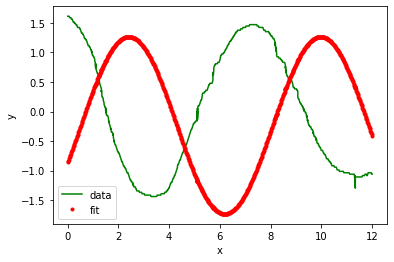

In [7]:
obj.plot_graph(k=100)

In [6]:
obj.automatic_phase_shift()

In [245]:
p = obj.fit_result.params
# print('y = {1:} + {2:}*cos({0:}*x) + {3:}*cos(2*{0:}*x) + {4:}*cos(3*{0:}*x) + {5:}*cos(4*{0:}*x) + {6:}*cos(5*{0:}*x) + {7:}*cos(6*{0:}*x) + {8:}*cos(7*{0:}*x) + {9:}*sin({0:}*x) + {10:}*sin(2*{0:}*x) + {11:}*sin(3*{0:}*x) + {12:}*sin(4*{0:}*x) + {13:}*sin(5*{0:}*x) + {14:}*sin(6*{0:}*x) + {15:}*sin(7*{0:}*x)'.format(p['w'],p['a0'],p['a1'],p['a2'],p['a3'],p['a4'],p['a5'],p['a6'],p['a7'],p['b1'],p['b2'],p['b3'],p['b4'],p['b5'],p['b6'],p['b7']))
print('y = {1:} + {2:}*cos({0:}*x) + {3:}*sin({0:}*x)'.format(p['w'],p['a0'],p['a1'],p['b1']))

y = -0.23374437746402574 + 0.42984553761846805*cos(0.8302146436121586*x) + 1.437346893422111*sin(0.8302146436121586*x)


In [247]:
obj.d2y_dt2

-0.0041841004184100415

In [246]:
obj.dy_dt

[0,
 -3,
 -4,
 -4,
 -5,
 -6,
 -7,
 -7,
 -7,
 -6,
 -5,
 -6,
 -6,
 -6,
 -7,
 -7,
 -8,
 -8,
 -8,
 -6,
 -6,
 -7,
 -8,
 -10,
 -10,
 -9,
 -9,
 -9,
 -8,
 -7,
 -5,
 -4,
 -3,
 -3,
 -4,
 -6,
 -8,
 -10,
 -11,
 -12,
 -13,
 -14,
 -14,
 -14,
 -14,
 -14,
 -13,
 -13,
 -13,
 -12,
 -12,
 -12,
 -12,
 -13,
 -13,
 -14,
 -15,
 -15,
 -16,
 -16,
 -15,
 -14,
 -13,
 -10,
 -8,
 -6,
 -4,
 -2,
 0,
 1,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 1,
 -1,
 -1,
 -2,
 -3,
 -4,
 -5,
 -6,
 -6,
 -7,
 -7,
 -6,
 -5,
 -6,
 -6,
 -6,
 -7,
 -7,
 -8,
 -9,
 -7,
 -6,
 -7,
 -7,
 -8,
 -10,
 -10,
 -9,
 -9,
 -9,
 -8,
 -7,
 -5,
 -3,
 -3,
 -3,
 -4,
 -6,
 -8,
 -10,
 -11,
 -12,
 -13,
 -14,
 -14,
 -14,
 -14,
 -14,
 -13,
 -14,
 -13,
 -12,
 -12,
 -12,
 -12,
 -12,
 -14,
 -14,
 -14,
 -15,
 -16,
 -16,
 -15,
 -14,
 -12,
 -10,
 -8,
 -6,
 -3,
 -2,
 0,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 1,
 -1,
 -2,
 -3,
 -3,
 -4,
 -5,
 -5,
 -6,
 -7,
 -7,
 -6,
 -5,
 -6,
 -6,
 -6,
 -6,
 -7,
 -8,
 -9,
 -8,
 -7,
 -7,
 -7,
 -8,
 -10,
 -10,
 -9,
 -9,
 -9,
 -8,
 -7,
 -5,
 -4,
 -2

## New Approach

In [9]:
import numpy, scipy.optimize, pickle

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, p):  return 63.44873570506242 * numpy.sin(0.014352379687278*t + p) + 265.0112055523494
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=0.0)
#     A, w, p, c = popt
    p = popt
    A = 63.44873570506242
    w = 0.014352379687278
    c = 265.0112055523494
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

In [6]:
phases = []
for i in range(len(loaded['cx'])):
    x = np.array(loaded['cx'][i])
    y = np.array(loaded['cy'][i])
    res = fit_sin(x,y)
    phases.append(res['phase'])

In [7]:
params = {
    'amp': 63.44873570506242,
    'omega': 0.014352379687278,
    'offset': 265.0112055523494,
    'phase': phases,
    'fit_func': 'A * np.sin(w*x + p) + c'
}

In [10]:
with open('learnt_params.pkl', 'wb') as f:
    pickle.dump(params, f)